In [31]:
from pathlib import Path
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon
import numpy as np
import seaborn as sns
import hvplot.pandas
import h5py
from tqdm import tqdm, trange

In [86]:
relevant_columns = ['global_oid', 'image_oid', 'timestep', 'center_x', 'center_y']


def read_table_from_hdf(path):
    columns = ['object_id', 'labelimage_oid', 'timestep', 'Size in pixels', 'Center of the object_0', 'Center of the object_1']
    df = pd.read_hdf(path, columns=columns)
    df.rename(columns={'object_id':'global_oid', 
                                'labelimage_oid':'image_oid',
                                'Center of the object_0': 'center_x',
                                'Center of the object_1': 'center_y'}, inplace=True)
    df = df[relevant_columns]

    return df.convert_dtypes()

def merge_multiple_hdfs(paths):
    n_files = len(paths)

    df = pd.DataFrame(columns=relevant_columns)
    for i, path in enumerate(paths):
        sub_df = read_table_from_hdf(path)
        sub_df.timestep = sub_df.timestep + i * 30
        df = pd.concat([df, sub_df])

    return df


In [87]:
base_path = Path(r'C:\Data\Code\MicroscopyPipeline\3pos\pos35')
files = ['C2_enhanced_half_(0, 30)-data.h5',
         'C2_enhanced_half_(30, 60)-data.h5',
         'C2_enhanced_half_(60, 90)-data.h5',
         'C2_enhanced_half_(90, 120)-data.h5',
         'C2_enhanced_half_120_to_end-data.h5'
         ]
paths = [base_path / file for file in files]
# print(paths)
assert all([path.exists() for path in paths])

In [88]:
# df1 = read_table_from_hdf(paths[0])
# df2 = read_table_from_hdf(paths[1])

In [89]:
# df1

In [90]:
# df = pd.DataFrame(columns=relevant_columns)

# df = pd.concat([df, df1])

In [91]:
# df

In [92]:
df = merge_multiple_hdfs(paths)

c:\Data\Code\venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'User Label'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Data\Code\venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'Predicted Class'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
c:\Data\Code\venv\lib\site-packages\tables\path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'Probability of Label 1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check

In [98]:
dtypes = {'global_oid': np.uint16,
          'image_oid': np.uint16,
          'timestep': np.uint16,
          'center_x': np.float16,
          'center_y': np.float16}
df = df.astype(dtype=dtypes)
df.dtypes

global_oid     uint16
image_oid      uint16
timestep       uint16
center_x      float16
center_y      float16
dtype: object

In [99]:
df.to_hdf(base_path/'merged_data.h5', key='exported_data', mode='w')

In [11]:
# f = h5py.File(r'3pos\pos35\C2_enhanced_half_(60, 90)-data.h5')

In [12]:
# f.keys()

In [13]:
# f.get('exported_data')

In [14]:

# df.head()

In [60]:
magnification_towards_camera = 1
pixel_size_in_microns = 0.65 * magnification_towards_camera
calibration_squared_microns_to_squared_pixel = pixel_size_in_microns ** 2
typical_cell_area_microns = 400

In [61]:
def compute_voronoi(df):
    #print(df.head())
    vor = Voronoi(df[['center_x', 'center_y']])
    # = pd.DataFrame()

    df['vertice_ids'] = [vor.regions[i] for i in vor.point_region]
    df['valid_region'] = [True if min(l) != -1 else False for l in df.vertice_ids]
    df['vertices'] = [np.array([vor.vertices[vertice_id] for vertice_id in vertice_ids]) for vertice_ids in df.vertice_ids]

    return df

def compute_voronoi_stats(df):
    df['area'] = [Polygon(vert).area*calibration_squared_microns_to_squared_pixel for vert in df.vertices]
    df['perimeter'] = [Polygon(vert).length*pixel_size_in_microns for vert in df.vertices]
    
    horizontal_bins = range(0, 2080, 20)
    df['bins'] = pd.cut(df.center_x, bins=horizontal_bins, labels=range(len(horizontal_bins)-1))

    return df

In [62]:
valid_regions_df = df.groupby('timestep').apply(compute_voronoi).query('valid_region')
# valid_regions_df.head()
vor_stats_df = valid_regions_df.groupby('timestep').apply(compute_voronoi_stats)
vor_stats_df.head()

,global_oid,image_oid,timestep,center_x,center_y,vertice_ids,valid_region,vertices,area,perimeter,bins
1,1,2,0,89.320984,7.101852,"[1846, 1149, 1148, 1842]",True,"[[161.448397879465, -1563.9332719292586], [-18...",652843.137389,34338.944091,4
2,2,3,0,125.847328,8.353689,"[1846, 1842, 1841, 1843, 1844, 1845]",True,"[[161.448397879465, -1563.9332719292586], [106...",28715.052177,2117.216656,6
3,3,4,0,233.079254,10.303541,"[1845, 1115, 1117, 1116, 1844]",True,"[[188.65963328316207, -496.42335060113635], [2...",7853.401696,710.331660,11
5,5,6,0,517.42981,8.889361,"[1112, 514, 1103, 1101, 1106, 1107, 1111]",True,"[[533.5243166216513, 18.730160327901853], [529...",20029.478266,1343.802545,25
6,6,7,0,548.914307,7.820408,"[1114, 513, 514, 1112]",True,"[[556.0374780207678, 26.851051883508177], [562...",702.603869,166.618261,27


In [68]:
vor_stats_df.timestep.describe()

count     251353
unique       145
top          123
freq        1937
Name: timestep, dtype: int64

In [63]:
def calculate_kymograph(df):
    #print(df.head())
    #return df.agg(mean_area=('area', 'mean'),
    #              std_area=('area', 'std'),
    #              mean_perimeter=('perimeter', 'mean'),
    #              std_perimeter=('perimeter', 'std'))
    return df.agg({'area': ['mean', 'std'],
                   'perimeter': ['mean', 'std']})
    
    #print(df.asdfasdf)

In [69]:
kymograph_df = vor_stats_df.query('area.quantile(.05) < area < area.quantile(.95)').groupby(['timestep', 'bins']).apply(calculate_kymograph)
kymograph_df.index.rename(names=['timestep', 'bins', 'statistic'], inplace=True)
kymograph_df.head()

area   perimeter
timestep bins statistic                         
0        0    mean       1817.362490  231.009923
              std        1124.476611   88.391964
         1    mean        948.434399  129.584218
              std         597.318915   54.350685
         2    mean        653.998095  101.818895

In [72]:
kymograph_df.index

MultiIndex([(  0,   0, 'mean'),
            (  0,   0,  'std'),
            (  0,   1, 'mean'),
            (  0,   1,  'std'),
            (  0,   2, 'mean'),
            (  0,   2,  'std'),
            (  0,   3, 'mean'),
            (  0,   3,  'std'),
            (  0,   4, 'mean'),
            (  0,   4,  'std'),
            ...
            (144,  98, 'mean'),
            (144,  98,  'std'),
            (144,  99, 'mean'),
            (144,  99,  'std'),
            (144, 100, 'mean'),
            (144, 100,  'std'),
            (144, 101, 'mean'),
            (144, 101,  'std'),
            (144, 102, 'mean'),
            (144, 102,  'std')],
           names=['timestep', 'bins', 'statistic'], length=26700)

In [73]:
a = kymograph_df.reset_index().query('statistic == "mean"').pivot(index='timestep', columns='bins', values='area')
a.head()


bins,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,102
timestep,,,,,,,,,,,,,,,,,,,,,
0,1817.362490,948.434399,653.998095,826.105629,743.800692,686.234508,759.418880,708.958653,735.592898,675.961692,...,693.988493,714.683439,821.260910,677.199971,750.013151,736.730074,807.332266,842.268855,1622.903563,NaN
1,1801.934832,1009.568983,753.949496,683.414800,758.512803,684.815255,749.745211,750.489452,730.603461,672.230741,...,760.821386,688.161955,741.211830,705.173162,751.980018,717.390472,732.297693,772.909044,1176.758522,2805.862566
2,1892.931852,988.286295,796.882868,676.705611,733.607277,689.431722,765.624652,720.562642,746.751220,683.151519,...,716.522196,699.075678,736.177313,747.322951,703.739313,668.490184,710.894996,786.811047,1538.485555,NaN
3,1805.527073,1075.600055,757.604698,683.276296,723.583033,661.002957,757.937169,744.496155,760.561689,708.453625,...,757.811385,729.542609,704.608614,744.365622,702.837721,810.246596,680.478664,743.660761,1500.127628,NaN
4,2069.411583,885.752789,786.844653,715.412856,712.934515,660.140167,733.310277,742.045472,661.373159,704.545074,...,917.000350,698.369310,692.706835,760.846239,702.858194,722.072241,837.824854,738.321498,1438.175438,3649.895669


In [77]:
# a.columns = pd.to_numeric(a.columns)
# a.size

14935

In [78]:
a.sort_index(axis='columns').hvplot.heatmap(flip_yaxis=True).opts(cmap='bky')

:HeatMap   [columns,index]   (value)

<AxesSubplot:xlabel='bins', ylabel='timestep'>

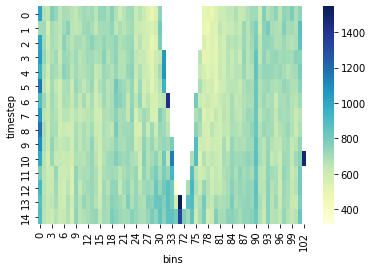

In [196]:
sns.heatmap(a.sort_index(axis='columns'), cmap="YlGnBu", mask=a.isnull())

In [190]:
a.isnull()

bins,0,1,2,3,4,5,6,7,8,9,...,76,32,75,33,74,102,34,73,35,72
timestep,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,True,True,True
5,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,True,True,True
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,True,True
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,True,True
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,True,True,True,True,True


<AxesSubplot:xlabel='timestep', ylabel='[area]'>

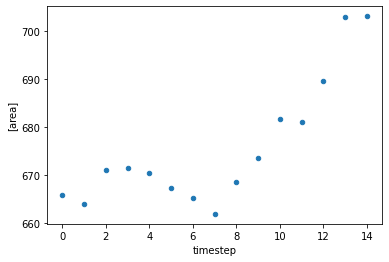

In [118]:
valid_regions_df.query('area < area.quantile(.90)').groupby('timestep').mean('area')[['area', 'perimeter']].reset_index().plot.scatter(x='timestep', y=['area'])

In [93]:
valid_regions_df.query('timestep == 0').vertices.iloc[500]

array([[1900.52625083,  706.40387652],
       [1906.48354016,  718.32341871],
       [1875.69610618,  745.92793619],
       [1853.12858069,  727.24454561],
       [1854.28704912,  723.05256599],
       [1883.63710058,  696.82400953]])

In [79]:
g = df.groupby('timestep').get_group(0)
vor = Voronoi(g[['center_x', 'center_y']])

vertice_ids = [vor.regions[i] for i in vor.point_region]
valid_region = [True if min(l) != -1 else False for l in vertice_ids]
vertices = [np.array([vor.vertices[vertice_id] for vertice_id in v_ids]) for v_ids in vertice_ids]

In [87]:
vertices[500]

array([[538.49297048, 709.92651906],
       [505.14056037, 740.76770812],
       [501.34523299, 740.52873628],
       [490.86800132, 734.21656634],
       [490.15717841, 689.71283353],
       [522.72826975, 684.09640306],
       [538.14194409, 706.46915412]])

In [89]:
Polygon(vertices[500]).area

1896.0902781701266

In [71]:
valid_regions_df[['center_x', 'center_y', 'vertices']]
a_df = pd.DataFrame(valid_regions_df[['vertices']].iloc[3])
a_df.iloc[0].shape

(1,)

<AxesSubplot:>

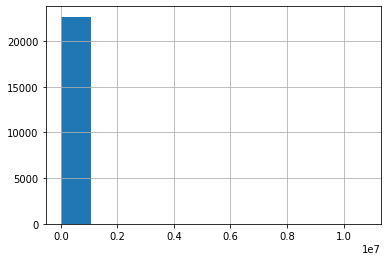

In [49]:
pd.Series([float(Polygon(coords).length) for coords in valid_regions_df.vertices]).hist()

In [7]:
df.timestep.describe()

count    22950.000000
mean         7.136427
std          4.306788
min          0.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         14.000000
Name: timestep, dtype: float64

In [18]:
df.groupby('timestep').get_group(0)[['Center of the object_0', 'Center of the object_1']]

,Center of the object_0,Center of the object_1
0,33.849056,7.615094
1,89.320984,7.101852
2,125.847328,8.353689
3,233.079254,10.303541
4,277.107574,4.498008
...,...,...
1446,34.593021,2042.720947
1447,126.043480,2044.434814
1448,376.926819,2045.195068
1449,192.949158,2045.457642


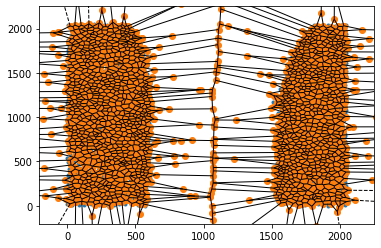

In [31]:
points = df.groupby('timestep').get_group(0)[['center_x', 'center_y']]
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)

In [33]:
vor.points

array([[  33.84905624,    7.61509418],
       [  89.32098389,    7.10185194],
       [ 125.84732819,    8.35368919],
       ...,
       [ 376.92681885, 2045.19506836],
       [ 192.94915771, 2045.4576416 ],
       [2045.        , 2045.1739502 ]])

In [44]:
vor.points[300]

array([456.4621582, 444.6489563])

In [40]:
[vor.vertices[i] for i in vor.regions[vor.point_region[300]]]

[array([446.65376431, 415.27393223]),
 array([434.41539547, 420.91548053]),
 array([426.86000583, 445.48408499]),
 array([460.67607442, 466.38852852]),
 array([472.32581344, 467.74589369]),
 array([475.87751448, 465.08785533]),
 array([480.10639675, 425.38480465])]

In [21]:
valid_points = [i for i in vor.point_region  if min(vor.regions[i]) != -1]
valid_regions = [vor.regions[i]  for i in vor.point_region if min(vor.regions[i]) != -1]

In [22]:
valid_regions[0]

[1798, 535, 534, 1794]

In [23]:
subdf = df.groupby('timestep').get_group(0).copy()
subdf['region'] = [vor.regions[i] for i in vor.point_region]
subdf['valid_region'] = [True if min(l) != -1 else False for l in subdf.region]
subdf.head()

,object_id,timestep,labelimage_oid,User Label,Predicted Class,Probability of Label 1,Probability of Label 2,Bounding Box Maximum_0,Bounding Box Maximum_1,Bounding Box Minimum_0,Bounding Box Minimum_1,Size in pixels,Center of the object_0,Center of the object_1,region,valid_region
0,0,0,1,0,Label 1,1.0,0.0,45.0,16.0,23.0,0.0,265.0,33.849056,7.615094,"[535, -1, 0, 210, 534]",False
1,1,0,2,0,Label 1,1.0,0.0,101.0,18.0,78.0,0.0,324.0,89.320984,7.101852,"[1798, 535, 534, 1794]",True
2,2,0,3,0,Label 1,1.0,0.0,141.0,19.0,113.0,0.0,393.0,125.847328,8.353689,"[1799, 1797, 1796, 1795, 1794, 1798]",True
3,3,0,4,0,Label 1,1.0,0.0,252.0,23.0,213.0,0.0,593.0,233.079254,10.303541,"[1799, 1071, 1073, 1072, 1797]",True
4,4,0,5,0,Label 1,1.0,0.0,293.0,12.0,265.0,0.0,251.0,277.107574,4.498008,"[2305, 1071, 1799, 1798, 535, -1, 1058, 2303]",False


In [24]:
#subdf = subdf.query('valid_region')

In [25]:
subdf['coordinates'] = [vor.vertices[i] for i in subdf.region]
subdf.head()

,object_id,timestep,labelimage_oid,User Label,Predicted Class,Probability of Label 1,Probability of Label 2,Bounding Box Maximum_0,Bounding Box Maximum_1,Bounding Box Minimum_0,Bounding Box Minimum_1,Size in pixels,Center of the object_0,Center of the object_1,region,valid_region,coordinates
0,0,0,1,0,Label 1,1.0,0.0,45.0,16.0,23.0,0.0,265.0,33.849056,7.615094,"[535, -1, 0, 210, 534]",False,"[[-182.37362971921902, -26360.027898374323], [..."
1,1,0,2,0,Label 1,1.0,0.0,101.0,18.0,78.0,0.0,324.0,89.320984,7.101852,"[1798, 535, 534, 1794]",True,"[[161.448397879465, -1563.9332719292586], [-18..."
2,2,0,3,0,Label 1,1.0,0.0,141.0,19.0,113.0,0.0,393.0,125.847328,8.353689,"[1799, 1797, 1796, 1795, 1794, 1798]",True,"[[188.65963328316207, -496.42335060113635], [1..."
3,3,0,4,0,Label 1,1.0,0.0,252.0,23.0,213.0,0.0,593.0,233.079254,10.303541,"[1799, 1071, 1073, 1072, 1797]",True,"[[188.65963328316207, -496.42335060113635], [2..."
4,4,0,5,0,Label 1,1.0,0.0,293.0,12.0,265.0,0.0,251.0,277.107574,4.498008,"[2305, 1071, 1799, 1798, 535, -1, 1058, 2303]",False,"[[264.9689350616553, 24.09798926965936], [256...."


In [27]:
subdf['perimeter'] = [float(Polygon(coords).length) for coords in subdf.coordinates]
subdf['area'] = [float(Polygon(coords).area) for coords in subdf.coordinates]

<AxesSubplot:>

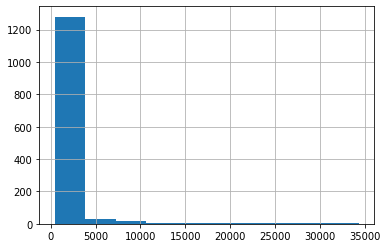

In [28]:
valid_points = subdf.query('valid_region')
valid_points.query('area < area.quantile(.95)').area.hist()

<AxesSubplot:>

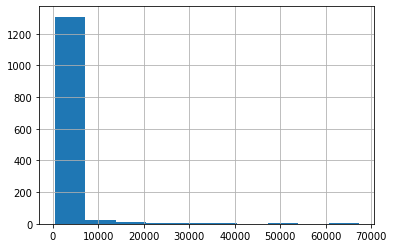

In [29]:
valid_points.query('perimeter < perimeter.quantile(.95)').area.hist()

In [37]:
cols = ['object_id', 'timestep', 'labelimage_oid', 'Center of the object_0', 'Center of the object_1', 'area', 'perimeter' ]
relevant_columns_df = subdf[cols].copy()
relevant_columns_df.rename(columns={'object_id':'global_oid', 
                            'labelimage_oid':'image_oid',
                            'Center of the object_0': 'center_x',
                            'Center of the object_1': 'center_y'}, inplace=True)
relevant_columns_df.head()

,global_oid,timestep,image_oid,center_x,center_y,area,perimeter
0,0,0,1,33.849056,7.615094,2.174100e+07,55748.759884
1,1,0,2,89.320984,7.101852,1.546041e+06,52858.302929
2,2,0,3,125.847328,8.353689,6.798767e+04,3261.657458
3,3,0,4,233.079254,10.303541,1.858793e+04,1092.817938
4,4,0,5,277.107574,4.498008,1.921010e+07,57153.629427


In [38]:
relevant_columns_df.to_csv('initial_voronoi_area_perimeter.csv')